In [54]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sa_basefunctions import *
from sa_SimulatedAnnealing import *
from kqc_custom import *
from qiskit import Aer,IBMQ
from ga_algorithm import GA
from ga_results import ga_Results_gen, ga_Results

In [96]:
def qaoa(x,y,gamma=3) :
    data_x = pd.DataFrame(x)
    data_y = pd.DataFrame(y)
    p = data_x.shape[1]
    Q = np.abs(data_x.corr())
    for i in range(p) : Q.iloc[i,i] = 0 
    r_squared_list=partial_r1(data_x,data_y)
    
    beta_new =  -Q.apply(sum,axis=1) -gamma*r_squared_list
    result_qaoa=kqc_custom.qubo_qaoa(Q,beta_new,backend)
    return(result_qaoa)

def qubo_qaoa(Q,beta,backend = Aer.get_backend("qasm_simulator")):
    algorithm_globals.massive = True
    p = Q.shape[0]
    mod = QuadraticProgram("my problem")
    linear = {"x"+str(i): beta[i] for i in range(p)}
    quadratic = {("x"+str(i),"x"+str(j)): Q.values[i,j] for i in range(p) for j in range(p)}

    for i in range(p) :
        mod.binary_var(name="x"+str(i))

    mod.minimize(linear=linear,quadratic=quadratic)
    quantum_instance = QuantumInstance(backend)
    mes = QAOA(quantum_instance=quantum_instance,rep=2)
    optimizer = MinimumEigenOptimizer(mes)
    result = optimizer.solve(mod)
    return([result,mod])

def mse(X,y):
    q = X.shape[0]
    xtx = np.matmul(X.T,X)
    xtxinv = np.linalg.inv(xtx)
    proj = np.matmul(np.matmul(X,xtxinv),X.T)
    mse = np.matmul(np.matmul(y.T,(np.identity(q)-proj)),y)/q
    return(mse)

def mse2(X,y):
    q = X.shape[0]
    np.concatenate([np.ones(q).reshape(-1,1),X],axis=1)
    xtx = np.matmul(X.T,X)
    xtxinv = np.linalg.inv(xtx)
    proj = np.matmul(np.matmul(X,xtxinv),X.T)
    mse = np.matmul(np.matmul(y.T,(np.identity(q)-proj)),y)/q
    return(mse)

def cn(X): 
    if X.shape[1]==1 : return(1)
    cordata = np.corrcoef(X.T)
    eig_value = np.linalg.eig(cordata)[0]
    return(np.max(eig_value)/np.min(eig_value))

def projection(X):
    xtx = np.matmul(X.T,X)
    xtxinv = np.linalg.inv(xtx)
    proj = np.matmul(np.matmul(X,xtxinv),X.T)
    return(proj)
    
def partial_r1(X,y):
    X = np.asarray(X);y=np.asarray(y).reshape((-1))
    n = X.shape[0]
    X_temp = pd.DataFrame(np.ones((n,1))); X = pd.DataFrame(X)
    X_temp = np.asarray(pd.concat([X_temp,X],axis=1))
    q=X_temp.shape[1]
    y = y-np.mean(y)
    partial_r_list = []
    SSRF = np.matmul(np.matmul(y.T,(np.identity(n)-projection(X_temp))),y)
    for i in range(1,q):
        ind = [i for i in range(i)] + [i for i in range(i+1,q)]
        SSRR = np.matmul(np.matmul(y.T,(np.identity(n)-projection(X_temp[:,ind]))),y)
        partial_r_list += [1-SSRF/SSRR]
    return(np.array(partial_r_list))

def partial_r2(X,y):
    n = X.shape[0]
    X_temp = pd.DataFrame(np.ones((n,1))); X = pd.DataFrame(X)
    X_temp = np.asarray(pd.concat([X_temp,X],axis=1)) ; y = np.asarray(y)
    p=X_temp.shape[1]
    y = y-np.mean(y)
    partial_r_list = []
    SSRF = np.matmul(np.matmul(y.T,(np.identity(n)-projection(X_temp))),y)
    for i in range(1,p):
        SSRR = np.matmul(np.matmul(y.T,(np.identity(n)-projection(X_temp[:,[0,i]]))),y)
        partial_r_list += [SSRF/SSRR]
    return(np.array(partial_r_list))

In [56]:
provider = IBMQ.load_account()
provider_real = IBMQ.get_provider(hub='ibm-q-kqc', group='internal', project='default')
# Qasm 시뮬레이터/Real_device 사용시
# backend = provider_real.get_backend("ibmq_qasm_simulator")

# 로컬 시뮬레이터 사용시
backend =Aer.get_backend('qasm_simulator')


ibmqfactory.load_account:WARNING:2022-10-18 20:21:13,123: Credentials are already in use. The existing account in the session will be replaced.


In [57]:
X,y = generate_dependent_sample(1000,200,beta_coef=[10,10,10,10,10,10,10,10,10,10],epsilon = 0.5)

In [58]:
lst = [60 for i in range(5)]
k=1
alpha=0.9
tau=1
objective = "aic"

In [59]:
sa = SimulatedAnnealing(pd.DataFrame(X),y,lst,k,alpha,tau,objective)
sa_value,sa_result,sa_log = sa.geometric()

In [60]:
X_choose = X[:,[bool(i) for i in sa_log.iloc[-1,:]]]

In [61]:
cor = np.corrcoef(X_choose.T)
eigval = np.linalg.eig(cor)[0]
np.max(eigval)/np.min(eigval)

98.65654887872063

In [62]:
import winsound
frequency = 2500  # Set Frequency To 2500 Hertz
duration = 1000  # Set Duration To 1000 ms == 1 second
winsound.Beep(frequency, duration)

In [63]:
X,y = generate_dependent_sample(1000,200,beta_coef=[10 for i in range(20)],epsilon = 20)

In [64]:
lst = [60 for i in range(10)]
k=2
alpha=0.9
tau=1
objective = "aic"

In [65]:
sa = SimulatedAnnealing(pd.DataFrame(X),y,lst,k,alpha,tau,objective)
sa_value,sa_result,sa_log = sa.geometric()

C:\Users\mhg95\Desktop\KQC\KQC Summer Project\kqc_custom\sa_SimulatedAnnealing.py:50: RuntimeWarning: overflow encountered in exp
  if np.random.rand(1) <= min(1, np.exp((obj(self.x.iloc[:, np.where(theta_zero)[0]], self.y)-obj(self.x.iloc[:, np.where(theta_star)[0]], self.y))/tau)):


In [66]:
import winsound
frequency = 2500  # Set Frequency To 2500 Hertz
duration = 1000  # Set Duration To 1000 ms == 1 second
winsound.Beep(frequency, duration)

In [67]:
from sklearn.linear_model import Lasso

In [68]:
X = pd.read_excel("data_x2.xlsx")
y = pd.read_excel("data_y2.xlsx")

In [69]:
lasso_mse = []
lasso_cn = []
ga_mse = []
ga_cn = []
sa_mse = []
sa_cn = []
qaoa_mse = []
qaoa_cn = []

for i in range(5):
    X,y = generate_dependent_sample(500,10,beta_coef=[10 for i in range(4)],epsilon = 5)
    
    la = Lasso()
    la.fit(X,y)
    X_choose = X[:,la.coef_ !=0]
    lasso_mse += [mse(X_choose,y)]
    lasso_cn += [cn(X_choose)]
        
    sa = SimulatedAnnealing(pd.DataFrame(X),y,lst,k,alpha,tau,objective)
    sa_value,sa_result,sa_log = sa.geometric()
    X_choose = X[:,[bool(i) for i in sa_log.iloc[-1,:]]]
    sa_mse += [mse(X_choose,y)]
    sa_cn  += [cn(X_choose)]
    
    ga_best_score, ga_best_solution, ga_result_log = GA(pd.DataFrame(X), y)
    X_choose = X[:,[bool(i) for i in ga_best_solution]]
    ga_mse += [mse(X_choose,y)]
    ga_cn  += [cn(X_choose)]
    
    result = qaoa(X,y)
    qaoa_coef_ = np.array([i for i in result[0]])
    X_choose = X[:,qaoa_coef_ !=0]
    qaoa_mse += [mse(X_choose,y)]
    qaoa_cn += [cn(X_choose)]


ValueError: at least one array or dtype is required

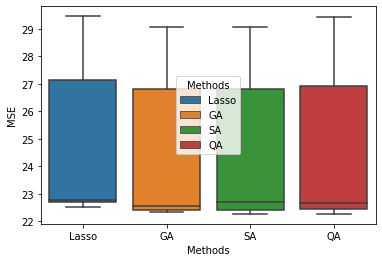

In [19]:
xlab = "Methods"
ylab = "MSE"
k=5 

plot_label = ["Lasso" for i in range(k)]+["GA" for i in range(k)]+["SA" for i in range(k)] + ["QA" for i in range(k)]
plot_value = lasso_mse+ga_mse+sa_mse+qaoa_mse
plot_data = pd.DataFrame([plot_label,plot_value ]).T
plot_data.columns = [xlab,ylab]
sns.boxplot(x= xlab,y=ylab,data = plot_data, hue=xlab,dodge=False)

plt.show()

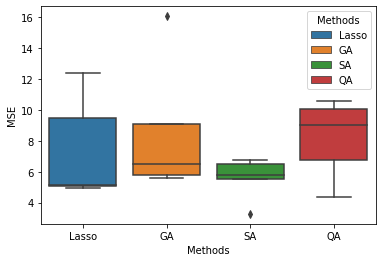

In [20]:
xlab = "Methods"
ylab = "MSE"
k=5 

plot_label = ["Lasso" for i in range(k)]+["GA" for i in range(k)]+["SA" for i in range(k)] + ["QA" for i in range(k)]
plot_value = lasso_cn+ga_cn+sa_cn+qaoa_cn
plot_data = pd.DataFrame([plot_label,plot_value ]).T
plot_data.columns = [xlab,ylab]
sns.boxplot(x= xlab,y=ylab,data = plot_data, hue=xlab,dodge=False)

plt.show()

In [90]:
lasso_mse = []
lasso_cn = []
ga_mse = []
ga_cn = []
sa_mse = []
sa_cn = []
qaoa_mse = []
qaoa_cn = []

for i in range(5):
    X,y = generate_dependent_sample(500,10,beta_coef=[5,4,3,3,3],epsilon = 10)
    
    la = Lasso()
    la.fit(X,y)
    X_choose = X[:,la.coef_ !=0]
    lasso_mse += [mse(X_choose,y)]
    lasso_cn += [cn(X_choose)]
        
    sa = SimulatedAnnealing(pd.DataFrame(X),y,lst,k,alpha,tau,objective)
    sa_value,sa_result,sa_log = sa.geometric()
    X_choose = X[:,[bool(i) for i in sa_log.iloc[-1,:]]]
    sa_mse += [mse(X_choose,y)]
    sa_cn  += [cn(X_choose)]
    
    ga_best_score, ga_best_solution, ga_result_log = GA(pd.DataFrame(X), y)
    X_choose = X[:,[bool(i) for i in ga_best_solution]]
    ga_mse += [mse(X_choose,y)]
    ga_cn  += [cn(X_choose)]
    
    result = qaoa(X,y)
    qaoa_coef_ = np.array([i for i in result[0]])
    X_choose = X[:,qaoa_coef_ !=0]
    qaoa_mse += [mse(X_choose,y)]
    qaoa_cn += [cn(X_choose)]

In [91]:
plot_data = pd.DataFrame([lasso_mse,ga_mse,sa_mse,qaoa_mse]).T
plot_data.columns = ["Lasso","GA","SA","QA"]


In [92]:
plot_data

,Lasso,GA,SA,QA
0,90.914725,89.720796,90.279860,104.965236
1,93.516533,91.434184,91.433693,98.163103
2,104.991019,97.969570,98.414799,110.878670
3,90.384113,88.811029,88.919375,95.987132
4,109.992091,107.800853,108.331024,121.928907


In [93]:
plot_data = pd.DataFrame([lasso_cn,ga_cn,sa_cn,qaoa_cn]).T
plot_data.columns = ["Lasso","GA","SA","QA"]


In [94]:
plot_data

,Lasso,GA,SA,QA
0,10.493100,10.980958,8.925054,5.669777
1,11.355456,9.088372,9.035112,4.713829
2,7.149584,16.861879,19.086475,3.355785
3,6.836793,16.090474,15.605027,3.292464
4,3.892740,31.697380,13.542787,5.945390


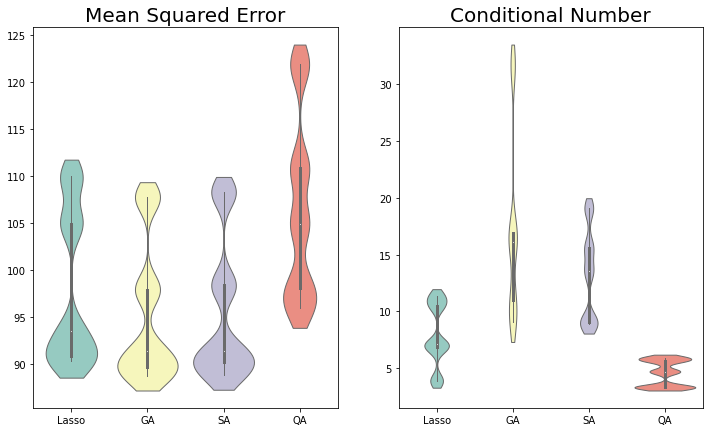

In [95]:
fig, axes = plt.subplots(1, 2)

xlab = "Methods"
ylab = "MSE"
k=5 

plot_data = pd.DataFrame([lasso_mse,ga_mse,sa_mse,qaoa_mse]).T
plot_data.columns = ["Lasso","GA","SA","QA"]

sns.violinplot(data = plot_data, palette="Set3", bw=.2, cut=1, linewidth=1, ax=axes[0])
axes[0].set_title("Mean Squared Error",fontsize=20)

xlab = "Methods"
ylab = "CN"
k=5 

plot_data = pd.DataFrame([lasso_cn,ga_cn,sa_cn,qaoa_cn]).T
plot_data.columns = ["Lasso","GA","SA","QA"]

sns.violinplot(data = plot_data, palette="Set3", bw=.2, cut=1, linewidth=1, ax=axes[1])
axes[1].set_title("Conditional Number",fontsize=20)

fig.set_size_inches(12,7, forward=True)

plt.show()

In [101]:
lasso_mse = []
lasso_cn = []
ga_mse = []
ga_cn = []
sa_mse = []
sa_cn = []
qaoa_mse = []
qaoa_cn = []

for i in range(5):
    X,y = generate_dependent_sample(500,10,beta_coef=[5,4,3,3,3],epsilon = 5)
    
    la = Lasso()
    la.fit(X,y)
    X_choose = X[:,la.coef_ !=0]
    lasso_mse += [1-mse(X_choose,y)/np.var(y)]
    lasso_cn += [cn(X_choose)]
        
    sa = SimulatedAnnealing(pd.DataFrame(X),y,lst,k,alpha,tau,objective)
    sa_value,sa_result,sa_log = sa.geometric()
    X_choose = X[:,[bool(i) for i in sa_log.iloc[-1,:]]]
    sa_mse += [1-mse(X_choose,y)/np.var(y)]
    sa_cn  += [cn(X_choose)]
    
    ga_best_score, ga_best_solution, ga_result_log = GA(pd.DataFrame(X), y)
    X_choose = X[:,[bool(i) for i in ga_best_solution]]
    ga_mse += [1-mse(X_choose,y)/np.var(y)]
    ga_cn  += [cn(X_choose)]
    
    result = qaoa(X,y,4)
    qaoa_coef_ = np.array([i for i in result[0]])
    X_choose = X[:,qaoa_coef_ !=0]
    qaoa_mse += [1-mse(X_choose,y)/np.var(y)]
    qaoa_cn += [cn(X_choose)]

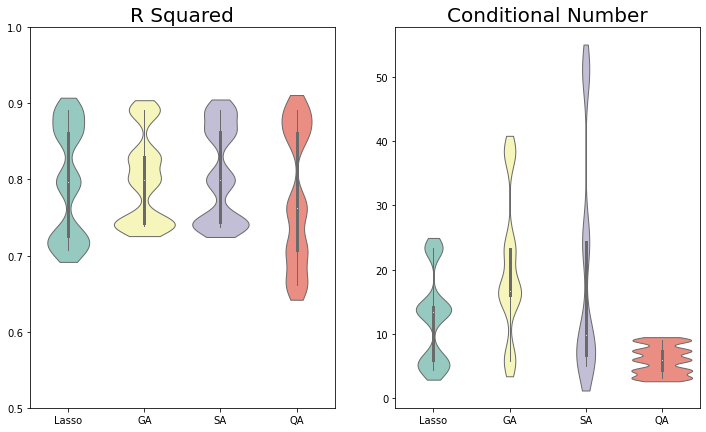

In [112]:
fig, axes = plt.subplots(1, 2)

xlab = "Methods"
ylab = "MSE"
k=5 

plot_data = pd.DataFrame([lasso_mse,ga_mse,sa_mse,qaoa_mse]).T
plot_data.columns = ["Lasso","GA","SA","QA"]

sns.violinplot(data = plot_data, palette="Set3", bw=.2, cut=1, linewidth=1, ax=axes[0])
axes[0].set_title("R Squared",fontsize=20)
axes[0].set(ylim=(0.5,1.0))

xlab = "Methods"
ylab = "CN"
k=5 

plot_data = pd.DataFrame([lasso_cn,ga_cn,sa_cn,qaoa_cn]).T
plot_data.columns = ["Lasso","GA","SA","QA"]

sns.violinplot(data = plot_data, palette="Set3", bw=.2, cut=1, linewidth=1, ax=axes[1])
axes[1].set_title("Conditional Number",fontsize=20)

fig.set_size_inches(12,7, forward=True)
plt.savefig("output.png")

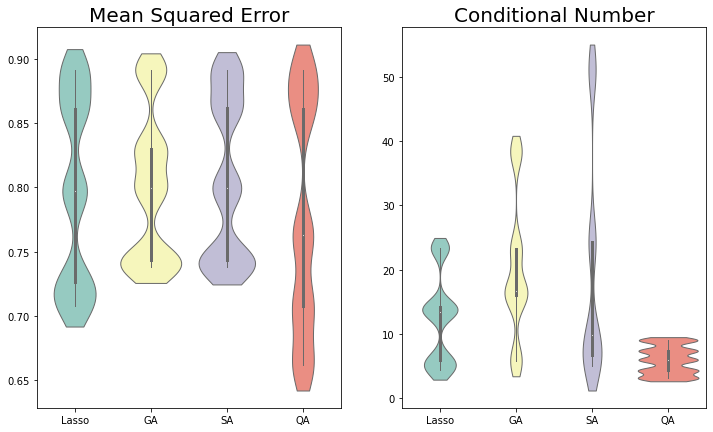

In [102]:
fig, axes = plt.subplots(1, 2)

xlab = "Methods"
ylab = "MSE"
k=5 

plot_data = pd.DataFrame([lasso_mse,ga_mse,sa_mse,qaoa_mse]).T
plot_data.columns = ["Lasso","GA","SA","QA"]

sns.violinplot(data = plot_data, palette="Set3", bw=.2, cut=1, linewidth=1, ax=axes[0])
axes[0].set_title("Mean Squared Error",fontsize=20)

xlab = "Methods"
ylab = "CN"
k=5 

plot_data = pd.DataFrame([lasso_cn,ga_cn,sa_cn,qaoa_cn]).T
plot_data.columns = ["Lasso","GA","SA","QA"]

sns.violinplot(data = plot_data, palette="Set3", bw=.2, cut=1, linewidth=1, ax=axes[1])
axes[1].set_title("Conditional Number",fontsize=20)

fig.set_size_inches(12,7, forward=True)

plt.show()

In [104]:
plt.show()

In [27]:
random_mse = [9772.32368973, 11688.71919556, 4388.79199625,16294.79059183, 6928.36316201, 3639.49333777, 7249.16440059, 3827.51069139,6520.14001642, 7378.09559555]
random_aic = [9324.23200324 , 9495.30193156, 8501.73174372, 9801.52318733, 8978.30131554, 8338.52220523, 9031.56393333, 8392.89236805,8905.57357681,9025.19328212 ]
random_cn = [36.622606319102324,31.546824026584037,27.621766450329893,23.948084728615505,39.73369419948681,50.325279686664715,46.43150679730744,52.46003654390028,30.712255105384713,32.664266431427194]

qaoa_mse = [0.20361136364158094,0.20567797221786055,0.20711822172309036,0.2014004582302389,0.20533710743291217,0.20414296035987206,0.20530395895940742,0.2055880301098506,0.20515946137232688, 0.2083350248527708]
qaoa_aic = [-1460.6197350893526,-1448.5211277803658,-1443.543082098006,-1471.5375762654628,-1452.1797767203732,-1458.0122972858424,-1452.341224156052,-1452.9585191958233,-1453.045294657306,-1435.685351443328]
qaoa_cn = [31.187548,31.160157,28.219160,31.581611,29.246376,27.740930,28.860275,29.938661,32.054005,27.362765]

sa_aic = [6173.005588141373,6356.176634845485,6843.305435117928,6852.2517880881705,6334.350793271787,7654.370114212047,6457.652451306338,-1449.7554399002604,-1504.3230104803972,6874.858245080024]
sa_cn = [302.8826994072043,266.1771860301313,106.70313549358455,66.977602070108,131.5477807915878,70.35042129833407,85.56413028828128,138.574670151229,29.359112450050056,135.59897687283208]
sa_mse = [379.2073453838262,454.52557726073866,773.0803492702648,798.9747480933064,455.5148629166886,1767.7231949570732,526.7520814103096,0.19191976457960688,0.1996388174739243,788.3449894102362]

ga_mse= [0.19706151583074175,2351.305992614394,0.20484211674292452,1728.7363057883908,3211.1097611427044,2387.401488673914,1619.4240622833568,2020.9850328914147,2427.3887970431556,1218.94877562771]
ga_aic=[-1455.3168886777328,7917.648641519284,-1434.5933115904786,7640.068408704925,8225.294323569009,7928.88325742538,7550.74829511638,7794.2627587929155,7949.4938366634005,7242.666554174152]
ga_cn=[61.20228400151781,49.45218754348459,54.99870070966981,74.56676305627985,47.721415048775775,62.11310187885415,45.40469208261756,103.46305341842452,60.22320940970151,36.164846168611156]

In [28]:
X = pd.read_excel("data_x2.xlsx")
y = pd.read_excel("data_y2.xlsx")

In [29]:
lasso_mse = []
lasso_cn = []
for i in range(10):
    la = Lasso()
    la.fit(X,y)
    X_choose = X.values[:,la.coef_ !=0]
    lasso_mse += [mse(X_choose,y)[0]]
    lasso_cn += [cn(X_choose)]

<ipython-input-2-6ea6b26d3199>:36: FutureWarning: Calling a ufunc on non-aligned DataFrames (or DataFrame/Series combination). Currently, the indices are ignored and the result takes the index/columns of the first DataFrame. In the future , the DataFrames/Series will be aligned before applying the ufunc.
Convert one of the arguments to a NumPy array (eg 'ufunc(df1, np.asarray(df2)') to keep the current behaviour, or align manually (eg 'df1, df2 = df1.align(df2)') before passing to the ufunc to obtain the future behaviour and silence this warning.
  mse = np.matmul(np.matmul(y.T,(np.identity(q)-proj)),y)/q
<ipython-input-2-6ea6b26d3199>:36: FutureWarning: Calling a ufunc on non-aligned DataFrames (or DataFrame/Series combination). Currently, the indices are ignored and the result takes the index/columns of the first DataFrame. In the future , the DataFrames/Series will be aligned before applying the ufunc.
Convert one of the arguments to a NumPy array (eg 'ufunc(df1, np.asarray(df2)') t

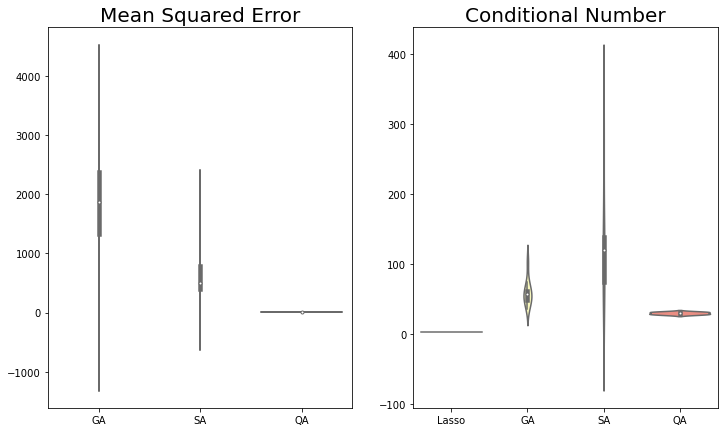

In [30]:
fig, axes = plt.subplots(1, 2)

xlab = "Methods"
ylab = "MSE"
k=5 

plot_data = pd.DataFrame([lasso_mse,ga_mse,sa_mse,qaoa_mse]).T
plot_data.columns = ["Lasso","GA","SA","QA"]

sns.violinplot(data = plot_data, palette="Set3",  ax=axes[0])
axes[0].set_title("Mean Squared Error",fontsize=20)

xlab = "Methods"
ylab = "CN"
k=5 

plot_data = pd.DataFrame([lasso_cn,ga_cn,sa_cn,qaoa_cn]).T
plot_data.columns = ["Lasso","GA","SA","QA"]

sns.violinplot(data = plot_data, palette="Set3",   ax=axes[1])
axes[1].set_title("Conditional Number",fontsize=20)

fig.set_size_inches(12,7, forward=True)

plt.show()

In [31]:
data1

NameError: name 'data1' is not defined

In [36]:
data1 = pd.read_csv("real_data/NMES1988.csv").iloc[:,1:]
y = data1['visits'].values
X = data1.loc[:,['nvisits', 'ovisits', 'novisits', 'emergency', 'hospital',"chronic","age","income","school"]].values

FileNotFoundError: [Errno 2] No such file or directory: 'real_data/NMES1988.csv'

In [37]:
mse_list_real1 = []
cn_list_real1 = []

la = Lasso()
la.fit(X,y)
X_choose = X[:,la.coef_ !=0]
mse_list_real1 += [mse2(X_choose,y)]
cn_list_real1 += [cn(X_choose)]
    
sa = SimulatedAnnealing(pd.DataFrame(X),y,lst,k,alpha,tau,objective)
sa_value,sa_result,sa_log = sa.geometric()
X_choose = X[:,[bool(i) for i in sa_log.iloc[-1,:]]]
mse_list_real1 += [mse2(X_choose,y)]
cn_list_real1  += [cn(X_choose)]

ga_best_score, ga_best_solution, ga_result_log = GA(pd.DataFrame(X), y)
X_choose = X[:,[bool(i) for i in ga_best_solution]]
mse_list_real1 += [mse2(X_choose,y)]
cn_list_real1  += [cn(X_choose)]

result = qaoa(X,y)
qaoa_coef_ = np.array([i for i in result[0]])
X_choose = X[:,qaoa_coef_ !=0]
mse_list_real1 += [mse2(X_choose,y)]
cn_list_real1 += [cn(X_choose)]

TypeError: '(slice(None, None, None), array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False]))' is an invalid key

In [38]:
rsquare1_list = 1-mse_list_real1/np.var(y)

ValueError: Length of passed values is 0, index implies 1.

In [39]:
rsquare1_list 

NameError: name 'rsquare1_list' is not defined

In [40]:
cn_list_real1

[]

In [41]:
data2 = pd.read_csv("real_data/CASchools.csv").iloc[:,1:]

FileNotFoundError: [Errno 2] No such file or directory: 'real_data/CASchools.csv'

In [42]:
data2 = pd.read_csv("real_data/CASchools.csv").iloc[:,1:]
y = data2["expenditure"].values
X = data2.loc[:,["students","teachers","calworks","lunch","computer","income","english","read","math"]].values

NameError: name 'data2' is not defined

In [43]:
mse_list_real2 = []
cn_list_real2 = []

la = Lasso()
la.fit(X,y)
X_choose = X[:,la.coef_ !=0]
mse_list_real2 += [mse2(X_choose,y)]
cn_list_real2 += [cn(X_choose)]
    
sa = SimulatedAnnealing(pd.DataFrame(X),y,lst,k,alpha,tau,objective)
sa_value,sa_result,sa_log = sa.geometric()
X_choose = X[:,[bool(i) for i in sa_log.iloc[-1,:]]]
mse_list_real2 += [mse2(X_choose,y)]
cn_list_real2  += [cn(X_choose)]

ga_best_score, ga_best_solution, ga_result_log = GA(pd.DataFrame(X), y)
X_choose = X[:,[bool(i) for i in ga_best_solution]]
mse_list_real2 += [mse2(X_choose,y)]
cn_list_real2  += [cn(X_choose)]

result = qaoa(X,y)
qaoa_coef_ = np.array([i for i in result[0]])
X_choose = X[:,qaoa_coef_ !=0]
mse_list_real2 += [mse2(X_choose,y)]
cn_list_real2 += [cn(X_choose)]

TypeError: '(slice(None, None, None), array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False]))' is an invalid key

In [44]:
rsquare2_list = 1-mse_list_real2/np.var(y)

ValueError: Length of passed values is 0, index implies 1.

In [45]:
rsquare2_list

NameError: name 'rsquare2_list' is not defined

In [46]:
cn_list_real2

[]

In [47]:
data3 = pd.read_csv("real_data/Guns.csv").iloc[:,1:]
data3["law"] = np.array(data3["law"]=="yes")*1

FileNotFoundError: [Errno 2] No such file or directory: 'real_data/Guns.csv'

In [48]:
y = data3['violent'].values
X = data3.loc[:,[ 'murder', 'robbery', 'prisoners', 'afam', 'cauc',
       'male', 'population', 'income', 'density',"law"]].values

NameError: name 'data3' is not defined

In [ ]:
mse_list_real3 = []
cn_list_real3 = []

la = Lasso()
la.fit(X,y)
X_choose = X[:,la.coef_ !=0]
mse_list_real3 += [mse2(X_choose,y)]
cn_list_real3 += [cn(X_choose)]
    
sa = SimulatedAnnealing(pd.DataFrame(X),y,lst,k,alpha,tau,objective)
sa_value,sa_result,sa_log = sa.geometric()
X_choose = X[:,[bool(i) for i in sa_log.iloc[-1,:]]]
mse_list_real3 += [mse2(X_choose,y)]
cn_list_real3  += [cn(X_choose)]

ga_best_score, ga_best_solution, ga_result_log = GA(pd.DataFrame(X), y)
X_choose = X[:,[bool(i) for i in ga_best_solution]]
mse_list_real3 += [mse2(X_choose,y)]
cn_list_real3  += [cn(X_choose)]

result = qaoa(X,y)
qaoa_coef_ = np.array([i for i in result[0]])
X_choose = X[:,qaoa_coef_ !=0]
mse_list_real3 += [mse2(X_choose,y)]
cn_list_real3 += [cn(X_choose)]

In [ ]:
rsquare3_list = 1-mse_list_real3/np.var(y)

In [ ]:
cn_list_real3

In [49]:
data4 = pd.read_csv("real_data/MASchools.csv").iloc[:,1:]
data4 = data4.loc[:,[ 'expreg', 'expspecial', 'expbil', 'expocc',
       'exptot', 'scratio', 'special', 'lunch', 'stratio','score4', 'income','english']].dropna()

FileNotFoundError: [Errno 2] No such file or directory: 'real_data/MASchools.csv'

In [ ]:
y = data4['income'].values
X = data4.loc[:,[ 'expreg', 'expspecial', 'expbil', 'expocc',
       'exptot', 'scratio', 'special', 'lunch', 'stratio','english']].dropna().values

In [ ]:
mse_list_real4 = []
cn_list_real4 = []

la = Lasso()
la.fit(X,y)
X_choose = X[:,la.coef_ !=0]
mse_list_real4 += [mse2(X_choose,y)]
cn_list_real4 += [cn(X_choose)]
    
sa = SimulatedAnnealing(pd.DataFrame(X),y,lst,k,alpha,tau,objective)
sa_value,sa_result,sa_log = sa.geometric()
X_choose = X[:,[bool(i) for i in sa_log.iloc[-1,:]]]
mse_list_real4 += [mse2(X_choose,y)]
cn_list_real4  += [cn(X_choose)]

ga_best_score, ga_best_solution, ga_result_log = GA(pd.DataFrame(X), y)
X_choose = X[:,[bool(i) for i in ga_best_solution]]
mse_list_real4 += [mse2(X_choose,y)]
cn_list_real4  += [cn(X_choose)]

result = qaoa(X,y)
qaoa_coef_ = np.array([i for i in result[0]])
X_choose = X[:,qaoa_coef_ !=0]
mse_list_real4+= [mse2(X_choose,y)]
cn_list_real4 += [cn(X_choose)]

In [ ]:
rsquare4_list = 1-mse_list_real4/np.var(y)

In [ ]:
cn_list_real4

In [ ]:
data5 = pd.read_csv("real_data/Mortgage.csv").iloc[:,1:]
data5["married"] = np.array(data5["married"]=="yes")*1
data5["first"] = np.array(data5["first"]=="yes")*1
data5["selfemp"] = np.array(data5["selfemp"]=="yes")*1
data5["coborrower"] = np.array(data5["coborrower"]=="yes")*1

In [ ]:
y = data5['liability'].values
X = data5.loc[:,[ 'age', 'school', 'networth', 'interest', 'points', 'maturities',
       'years',   'tdiff', 'margin', 'liquid']].dropna().values

In [ ]:
mse_list_real5 = []
cn_list_real5 = []

la = Lasso()
la.fit(X,y)
X_choose = X[:,la.coef_ !=0]
mse_list_real5 += [mse2(X_choose,y)]
cn_list_real5 += [cn(X_choose)]
    
sa = SimulatedAnnealing(pd.DataFrame(X),y,lst,k,alpha,tau,objective)
sa_value,sa_result,sa_log = sa.geometric()
X_choose = X[:,[bool(i) for i in sa_log.iloc[-1,:]]]
mse_list_real5 += [mse2(X_choose,y)]
cn_list_real5  += [cn(X_choose)]

ga_best_score, ga_best_solution, ga_result_log = GA(pd.DataFrame(X), y)
X_choose = X[:,[bool(i) for i in ga_best_solution]]
mse_list_real5 += [mse2(X_choose,y)]
cn_list_real5  += [cn(X_choose)]

result = qaoa(X,y)
qaoa_coef_ = np.array([i for i in result[0]])
X_choose = X[:,qaoa_coef_ !=0]
mse_list_real5+= [mse2(X_choose,y)]
cn_list_real5 += [cn(X_choose)]

In [ ]:
rsquare5_list =  1-mse_list_real5/np.var(y)

In [ ]:
cn_list_real5

In [ ]:
algo_list = ["LASSO","SA","GA","QA"]

In [ ]:
plot_data = pd.DataFrame(np.concatenate([rsquare1_list,rsquare2_list,rsquare3_list,rsquare4_list,rsquare5_list],axis=0))
plot_data["CN"] = np.concatenate([cn_list_real1,cn_list_real2,cn_list_real3,cn_list_real4,cn_list_real5])
plot_data["Algorithm"] = [algo_list[j] for i in range(5) for j in range(4)]
plot_data["Data"] = ["data" +str(i+1) for i in range(5) for j in range(4)]
plot_data.columns = ["MSE","CN","Algorithm","Data"]

In [ ]:
import seaborn as sns
sns.set_theme(style="whitegrid")

g = sns.catplot(
    data=plot_data, kind="bar",
    x="Data", y="MSE", hue="Algorithm", palette="dark", alpha=.6, height=6
)
g.fig.suptitle('Coefficient of Determination',fontsize=20)
g.despine(left=True)
g.set_axis_labels("", "R Squared")
g.legend.set_title("")

In [ ]:
import seaborn as sns
sns.set_theme(style="whitegrid")

g = sns.catplot(
    data=plot_data, kind="bar",
    x="Data", y="CN", hue="Algorithm", palette="dark", alpha=.6, height=6,log=True
)
g.fig.suptitle('Conditional Number',fontsize=20)
g.despine(left=True)
g.set_axis_labels("", "CN")
g.legend.set_title("")

In [ ]:
plot_data = pd.DataFrame(np.concatenate([[rsquare1_list,rsquare2_list,rsquare3_list,rsquare4_list,rsquare5_list]],axis=1))

In [ ]:
plot_data.index = ["1. NMES1988","2. CASchools","3. Guns","4. MASchools","5. Mortgage"]
plot_data.columns = ["LASSO","SA","GA","QA"]

In [ ]:
plot_data.to_csv("Real_MSE.csv")

In [ ]:
plot_data = pd.DataFrame(np.concatenate([[cn_list_real1,cn_list_real2,cn_list_real3,cn_list_real4,cn_list_real5]],axis=1))

In [ ]:
plot_data.index = ["1. NMES1988","2. CASchools","3. Guns","4. MASchools","5. Mortgage"]
plot_data.columns = ["LASSO","SA","GA","QA"]

In [ ]:
plot_data.to_csv("Real_CN.csv")

In [51]:
plot_data = pd.read_csv("Real_CN2.csv")

In [52]:
plot_data["CN"] = np.concatenate([cn_list_real1,cn_list_real2,cn_list_real3,cn_list_real4,cn_list_real5])
plot_data["Algorithm"] = [algo_list[j] for i in range(5) for j in range(4)]
plot_data["Data"] = ["data" +str(i+1) for i in range(5) for j in range(4)]
plot_data.columns = ["MSE","CN","Algorithm","Data"]

NameError: name 'rsquare1_list' is not defined

In [ ]:
plot_data.to_csv("Real_MSE.csv")

In [ ]:
plot_data = pd.DataFrame(np.concatenate([rsquare1_list,rsquare2_list,rsquare3_list,rsquare4_list,rsquare5_list],axis=0))
plot_data["CN"] = np.concatenate([cn_list_real1,cn_list_real2,cn_list_real3,cn_list_real4,cn_list_real5])
plot_data["Algorithm"] = [algo_list[j] for i in range(5) for j in range(4)]
plot_data["Data"] = ["data" +str(i+1) for i in range(5) for j in range(4)]
plot_data.columns = ["MSE","CN","Algorithm","Data"]